<p style="color:yellow;font-size:18px;"><b>
Tanut Bumrungvongsiri  63340500026 <br>
Parapat patcharapimpisut 63340500046<br>
Ronnakon mekvimanloi 63340500051


# Key-Value Attention Mechanism Homework on Keras: Character-level Machine Translation (Many-to-Many, encoder-decoder)

In this homework, you will create an MT model with key-value attention mechnism that coverts names of constituency MP candidates in the 2019 Thai general election from Thai script to Roman(Latin) script. E.g. นิยม-->niyom 

In [1]:
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

--2023-04-28 14:36:28--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2023-04-28 14:36:28--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: 'thsarabunnew-webfont.ttf.22'

     0K .......... .......... .......... .......... .......... 52%  362K 0s
    50K .......... .......... ....

In [2]:
import tensorflow as tf
print(tf.__version__)

import matplotlib
import matplotlib.font_manager as fm

fm.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
matplotlib.rc('font', family='TH Sarabun New')

2.10.0


In [3]:
# %matplotlib inline
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
import numpy as np

import random

## Load Dataset
We have generated a toy dataset using names of constituency MP candidates in 2019 Thai General Election from elect.in.th's github(https://github.com/codeforthailand/dataset-election-62-candidates) and tltk (https://pypi.org/project/tltk/) library to convert them into Roman script.

<img src="https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/images/dataset_diagram.png" alt="Drawing" style="width: 500px;"/>


In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# import shutil
# shutil.copy("/content/drive/MyDrive/mp_name_th_en.csv", "/content/mp_name_th_en.csv")

In [6]:
import csv

with open('mp_name_th_en.csv', 'r', encoding='utf-8') as file:
    readCSV = csv.reader(file)
    name_th = []
    name_en = []
    for row in readCSV:
        name_th.append(row[0])
        name_en.append(row[1])

In [7]:
for th, en in zip(name_th[:10],name_en[:10]):
    print(th,en)

ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak


## Task1: Preprocess dataset for Keras
* 2 dictionaries for indexing (1 for input and another for output)
* DON'T FORGET TO INCLUDE special token for padding
* DON'T FORGET TO INCLUDE special token for the end of word symbol (output)
* Be mindful of your pad_sequences "padding" hyperparameter. Choose wisely (post-padding vs pre-padding)

In [8]:
def unique_char(words,output =0):
    dictionary = {}
    dictionary["<PAD>"] = 0
    index = 1
    for word in words:
        for char in set(word):
            if char not in dictionary:
                dictionary[char] = index
                index += 1
    if output==1:
        dictionary["<END>"] = index
    return dictionary

def reverse_dict(dictionary):
    rev_dict = {}
    for index,word in enumerate(dictionary):
        rev_dict[index] = word
    return rev_dict

dict_in = unique_char(name_th)
dict_out = unique_char(name_en,1)
print(dict_in)
print(dict_out)

dict_in_rev = reverse_dict(dict_in)
dict_out_rev = reverse_dict(dict_out)
print(dict_in_rev)
print(dict_out_rev)

maxlen_in = len( max(name_th, key=len)) 
maxlen_out = len( max(name_en, key=len)) 

vocab_size_in = len(dict_in)
vocab_size_out = len(dict_out)

def data_generator(dictionary,dataset,maxlen,output):
    data = []
    for word in dataset:
        temp=[]
        for char in word:
            temp.append(dictionary[char])
        if output == 1:
            temp.append(dictionary['<END>'])
        data.append(temp)

    data = pad_sequences(data,maxlen=maxlen,padding='pre')
    return data

X = data_generator(dict_in,name_th,maxlen_in,0)
Y = data_generator(dict_out,name_en,maxlen_out,1)

X= to_categorical(X,vocab_size_in)
X=X.reshape(len(name_th),maxlen_in ,vocab_size_in)

Y= to_categorical(Y,vocab_size_out)
Y=Y.reshape(len(name_en),maxlen_out ,vocab_size_out)
print(X.shape,Y.shape) 

{'<PAD>': 0, 'ร': 1, 'ส': 2, 'ไ': 3, 'ี': 4, '์': 5, 'ห': 6, 'ก': 7, 'ั': 8, 'ช': 9, 'พ': 10, 'ธ': 11, 'ะ': 12, 'ิ': 13, 'ว': 14, 'ฒ': 15, 'ุ': 16, 'ม': 17, ' ': 18, 'ภ': 19, 'า': 20, 'ณ': 21, 'ษ': 22, 'ศ': 23, 'น': 24, 'ท': 25, 'ย': 26, 'ด': 27, 'เ': 28, 'อ': 29, 'ค': 30, 'ต': 31, '่': 32, 'ำ': 33, 'ฐ': 34, 'ญ': 35, 'ล': 36, 'ู': 37, 'ง': 38, 'ฏ': 39, 'ป': 40, 'บ': 41, 'ฎ': 42, 'จ': 43, 'โ': 44, 'ข': 45, 'ื': 46, 'ึ': 47, 'ถ': 48, 'ซ': 49, '้': 50, 'ฑ': 51, 'แ': 52, 'ผ': 53, '็': 54, 'ฮ': 55, 'ฉ': 56, 'ใ': 57, '๊': 58, 'ฆ': 59, 'ฌ': 60, 'ฟ': 61, 'ฬ': 62, 'ฝ': 63, '๋': 64}
{'<PAD>': 0, 'a': 1, 'r': 2, 's': 3, 'k': 4, 'i': 5, 'h': 6, 'p': 7, 't': 8, 'n': 9, 'u': 10, 'o': 11, 'w': 12, 'm': 13, 'd': 14, 'e': 15, 'c': 16, 'l': 17, 'g': 18, 'y': 19, 'b': 20, 'f': 21, '-': 22, '<END>': 23}
{0: '<PAD>', 1: 'ร', 2: 'ส', 3: 'ไ', 4: 'ี', 5: '์', 6: 'ห', 7: 'ก', 8: 'ั', 9: 'ช', 10: 'พ', 11: 'ธ', 12: 'ะ', 13: 'ิ', 14: 'ว', 15: 'ฒ', 16: 'ุ', 17: 'ม', 18: ' ', 19: 'ภ', 20: 'า', 21: 'ณ', 22: 'ษ', 23:

# Attention Mechanism
## Task 2: Code your own (key-value) attention mechnism
* PLEASE READ: you DO NOT have to follow all the details in (Daniluk, et al. 2017). You just need to create a key-value attention mechanism where the "key" part of the mechanism is used for attention score calculation, and the "value" part of the mechanism is used to encode information to create a context vector.  
* Define global variables
* fill code for one_step_attention function
* Hint: use keras.layers.Lambda 
* Hint: you will probably need more hidden dimmensions than what you've seen in the demo


In [9]:
from tensorflow.keras.activations import softmax
from tensorflow.keras.layers import Lambda
def softMaxAxis1(x):
    return softmax(x,axis=1)


In [10]:
#These are global variables (shared layers)
## Fill your code here
## you are allowed to use code in the demo as your template. 

#repeater = ???
#concatenator = ???

repeator = RepeatVector(maxlen_in)
concatenator = Concatenate(axis=-1)

#Key-values (Hint)
splitter = Lambda(lambda x:tf.split(x, num_or_size_splits=2,axis=2)) 

#fatten_1 = ???
#fatten_2 = ???

fattn_1 = Dense(128, activation = "tanh")
fattn_2 = Dense(1, activation = "relu")

#activator = ???
#dotor = ???

activator = Activation(softMaxAxis1, name='attention_scores') 
dotor = Dot(axes = 1)

In [11]:
def one_step_attention(a, s_prev):
    s_prev = repeator(s_prev)
    
    key , value = splitter(a)

    #concat = ...key...
    concat = concatenator([key,s_prev])
    e = fattn_1(concat)
    energies = fattn_2(e)
    attention_scores = activator(energies)
    #context = ...value...
    context = dotor([attention_scores,value])


    return context , attention_scores ,energies  # return whatever you need to complete this homework 

## Task3: Create and train your encoder/decoder model here
* HINT: you will probably need more hidden dimmensions than what you've seen in the demo

In [12]:
n_h = 64 #hidden dimensions for encoder 
n_s = 128 #hidden dimensions for decoder
Tx , Ty = maxlen_in, maxlen_out

encoder_LSTM =  Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, Tx, n_h*2))
decoder_LSTM_cell = LSTM(n_s, return_state = True) #decoder_LSTM_cell
output_layer = Dense(vocab_size_out, activation="softmax") #softmax output layer

In [13]:
#FILL CODE HERE :Hint --> heatmap in CNN + GradCAM

def model(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
    
    # Define the input of your model
    X = Input(shape=(Tx, vocab_size))
    # Define hidden state and cell state for decoder_LSTM_Cell
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = list()

    #Encoder Bi-LSTM
    # h = Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(-1, Tx, n_h*2))(X)
    h = encoder_LSTM(X)
    #Iterate for Ty steps (Decoding)
    for t in range(Ty):
    
        #Perform one step of the attention mechanism to calculate the context vector at timestep t
        context , attention_scores ,energies = one_step_attention(h, s)
       
        # Feed the context vector to the decoder LSTM cell
        s, _, c = decoder_LSTM_cell(context,initial_state=[s,c])
           
        # Pass the decoder hidden output to the output layer (softmax)
        out = output_layer(s)
        
        # Append an output list with the current output
        outputs.append(out)
    
    #Create model instance
    model = Model(inputs=[X,s0,c0],outputs=outputs)
    
    return model

def inference_encoder(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
    X = Input(shape=(Tx, vocab_size))

    h = encoder_LSTM(X)

    model = Model(inputs=[X],outputs=h)

    return model

def inference_decoder(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    h = Input(shape=(Tx,n_h*2), name='h')
    s = s0
    c = c0

    context, attention_scores, energies = one_step_attention(h, s)

    s, _, c = decoder_LSTM_cell(context, initial_state=[s, c])

    out = output_layer(s)

    model = Model(inputs=[h, s0, c0], outputs=[out, s, c, attention_scores, energies])

    return model

In [14]:
#FIT YOUR MODEL HERE

model = model(maxlen_in, maxlen_out, n_h, n_s, vocab_size_in, vocab_size_out)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 65)]     0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 20, 128)      66560       ['input_1[0][0]']                
                                                                                                  
 s0 (InputLayer)                [(None, 128)]        0           []                               
                                                                                                  
 lambda (Lambda)                [(None, 20, 64),     0           ['bidirectional[0][0]',          
                                 (None, 20, 64)]                  'bidirectional[0][0]',      

In [16]:
opt = Adam(learning_rate= 0.01, clipvalue=0.5)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])

s0 = np.zeros((len(name_th), n_s))
c0 = np.zeros((len(name_th), n_s))
outputs = list(Y.swapaxes(0,1))

model.fit([X, s0, c0], outputs, epochs=30, batch_size= 64)

Epoch 1/30
171/171 [==============================] - 44s 80ms/step - loss: 25.3940 - dense_2_loss: 0.1081 - dense_2_1_loss: 0.0908 - dense_2_2_loss: 0.0891 - dense_2_3_loss: 0.1007 - dense_2_4_loss: 0.1295 - dense_2_5_loss: 0.1790 - dense_2_6_loss: 0.2733 - dense_2_7_loss: 0.4246 - dense_2_8_loss: 0.7009 - dense_2_9_loss: 1.0957 - dense_2_10_loss: 1.6255 - dense_2_11_loss: 2.2286 - dense_2_12_loss: 2.6568 - dense_2_13_loss: 2.8631 - dense_2_14_loss: 2.8664 - dense_2_15_loss: 3.1102 - dense_2_16_loss: 2.7582 - dense_2_17_loss: 2.7437 - dense_2_18_loss: 1.3495 - dense_2_accuracy: 0.9984 - dense_2_1_accuracy: 0.9972 - dense_2_2_accuracy: 0.9960 - dense_2_3_accuracy: 0.9941 - dense_2_4_accuracy: 0.9888 - dense_2_5_accuracy: 0.9805 - dense_2_6_accuracy: 0.9626 - dense_2_7_accuracy: 0.9304 - dense_2_8_accuracy: 0.8639 - dense_2_9_accuracy: 0.7583 - dense_2_10_accuracy: 0.6116 - dense_2_11_accuracy: 0.3963 - dense_2_12_accuracy: 0.2354 - dense_2_13_accuracy: 0.1546 - dense_2_14_accuracy: 0.1

# Thai-Script to Roman-Script Translation
* Task 4: Test your model on 5 examples of your choice including your name! 
* Task 5: Show your visualization of attention scores on one of your example 

In [17]:
#task 4
#fill your code here
def prep_input(input_list):
    X = []
    for line in input_list:
        temp=[]
        for char in line:
            temp.append(dict_in[char])
        X.append(temp)
    X = pad_sequences(X,maxlen=maxlen_in)
    X= to_categorical(X,len(dict_in))
    X=X.reshape(len(input_list),maxlen_in ,len(dict_in))
    
    return X

EXAMPLES = ['สมชาย','สมศักดิ์','อดัม','ก้องภพ','ธนัท','ใจดี']
Sample = EXAMPLES
s0 = np.zeros((len(EXAMPLES), n_s))
c0 = np.zeros((len(EXAMPLES), n_s))
EXAMPLES = prep_input(EXAMPLES)

prediction = model.predict([EXAMPLES , s0, c0])
prediction = np.swapaxes(prediction,0,1)
prediction = np.argmax(prediction, axis = -1)

for j in range(len(prediction)):
    output = "".join([dict_out_rev[int(i)] for i in prediction[j]])
    output = output.replace('<PAD>','')
    output = output.replace('<END>','')
    print(Sample[j],output)  

1/1 [==============================] - 7s 7s/step
สมชาย somchai
สมศักดิ์ somsak
อดัม adam
ก้องภพ kongphop
ธนัท thanat
ใจดี caidi


### Plot the attention map
* If you need to install thai font: sudo apt install xfonts-thai
* this is what your visualization might look like:
--> https://drive.google.com/file/d/168J5SPSf4NNKj718wWUEDpUbh8QYZKux/view?usp=share_link

In [18]:
# EXAMPLES = ???
# h = inferEncoder_model.predict(EXAMPLES)
# s0 = ???
# c0 = ???
# ...
# Ty = 10
# for t in range(Ty):
#   out,s,c,attention_scores,energies = inferDecoder_model.predict([h,s0,c0])
# ...

EXAMPLES = ['สมชาย','สมศักดิ์','อดัม','ก้องภพ','ธนัท','ใจดี']
temp = EXAMPLES
inferEncoder_model = inference_encoder(maxlen_in, maxlen_out, n_h, n_s, vocab_size_in, vocab_size_out)
inferDecoder_model = inference_decoder(maxlen_in, maxlen_out, n_h, n_s, vocab_size_in, vocab_size_out)

s0 = np.zeros((len(EXAMPLES), n_s))
c0 = np.zeros((len(EXAMPLES), n_s))
s = s0
c = c0

EXAMPLES = prep_input(EXAMPLES)
h = inferEncoder_model.predict(EXAMPLES,verbose=0)

Ty = 30
score = []
attention_list = []

for t in range(Ty):
    out,s,c,attention_scores,energies = inferDecoder_model.predict([h,s,c],verbose=0)
    score.append(out)
    attention_list.append(attention_scores)
    # array=np.array(out)
    
prediction = np.swapaxes(score,0,1)
prediction = np.argmax(prediction, axis = -1)

attention_list = np.array(attention_list)
output_list=[]

for j in range(len(prediction)):
    a = [dict_out_rev[int(i)] for i in prediction[j]]
    output = "".join(a)
    output_list.append([[temp[j]],a])
    # output = output.replace('<PAD>','')
    # output = output.replace('<END>','')
    print(temp[j],output)  

สมชาย <PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>somchai<END><END><END><END><END><END><END><END><END><END><END><END>
สมศักดิ์ <PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>somsak<END><END><END><END><END><END><END><END><END><END><END><END>
อดัม <PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>adam<END><END><END><END><END><END><END><END><END><END><END><END>
ก้องภพ <PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>kongphop<END><END><END><END><END><END><END><END><END><END><END><END>
ธนัท <PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>thanat<END><END><END><END><END><END><END><END><END><END><END><END>
ใจดี <PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>caidi<END><END><END><END><END><END><END><END><END><END><END><END>


In [19]:
#task 5
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family']='TH Sarabun New'  #you can change to other font that works for you
#fill your code here


In [20]:
print("(number , Ty)",prediction.shape)
attention_list = np.swapaxes(attention_list,0,1)
print("(number Tx , Ty )",attention_list.shape)

(number , Ty) (6, 30)
(number Tx , Ty ) (6, 30, 20, 1)


In [21]:
def get_word_indices(word_list):
    start_index = None
    end_index = None
    
    for i in range(len(word_list)):
        if word_list[i] != '<PAD>':
            if start_index is None:
                start_index = i
            if word_list[i] == '<END>':
                end_index = i
                break
    
    return start_index, end_index

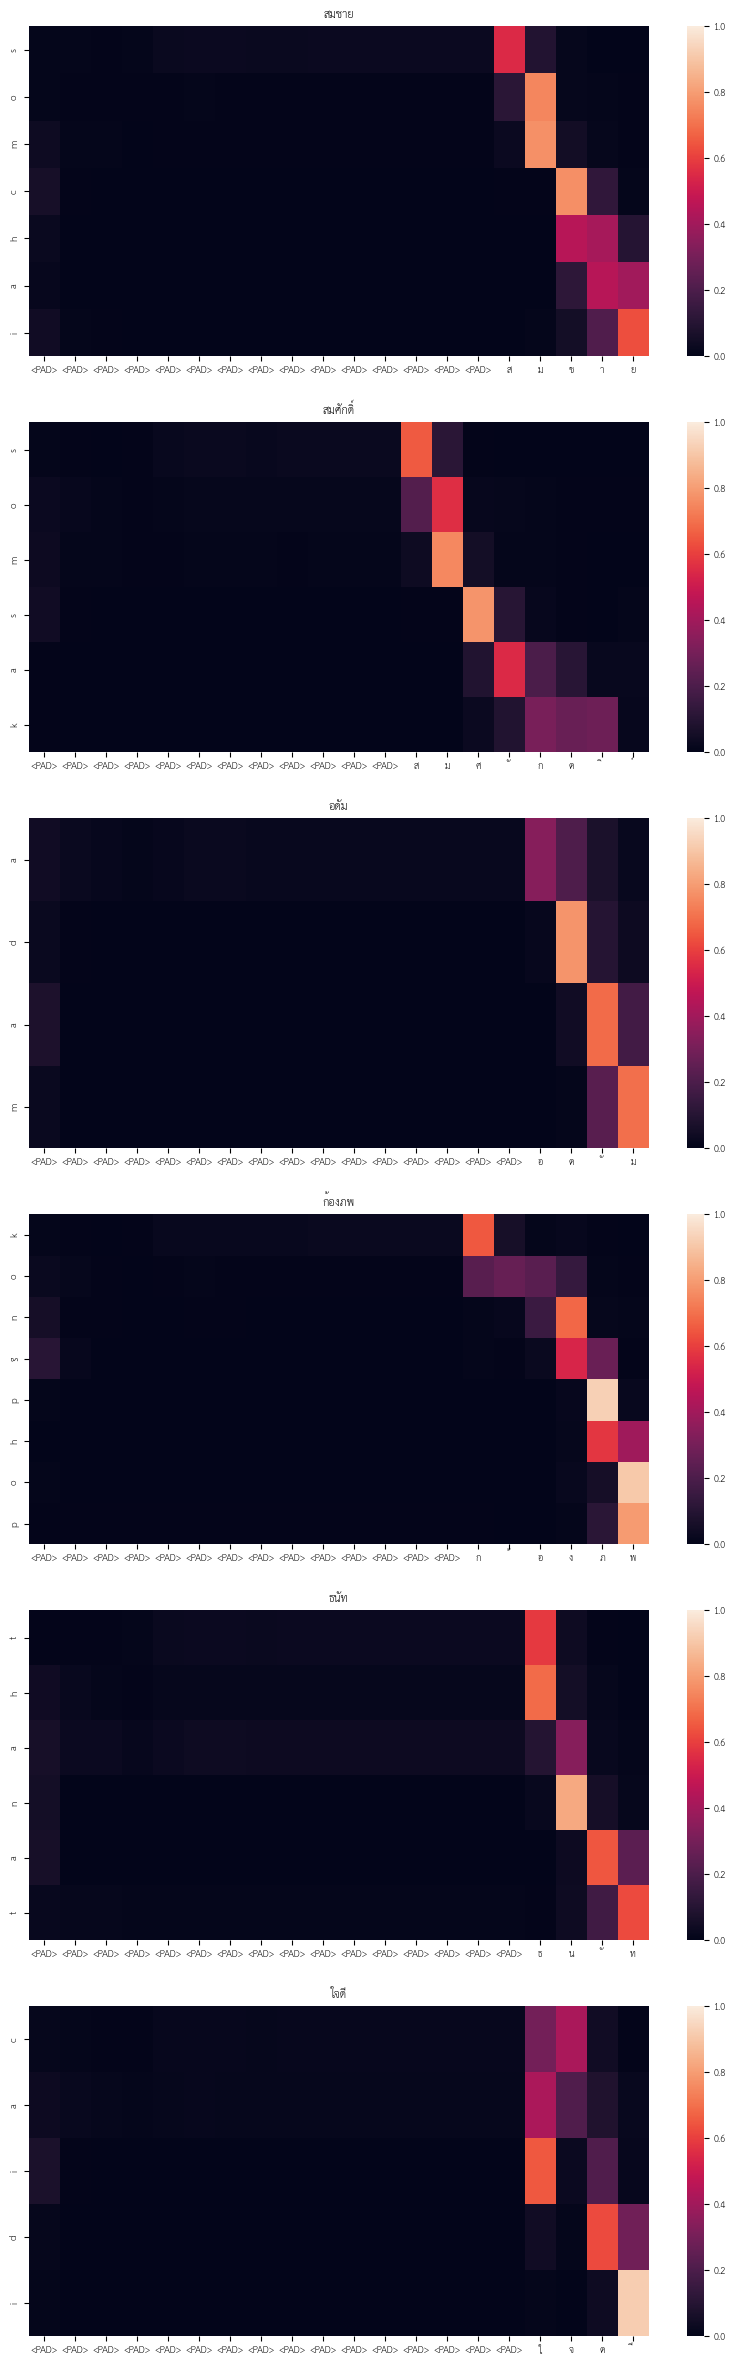

In [ ]:
def plotheat(output_list,atten):
    fig, ax = plt.subplots(nrows = 6, figsize=(20,50))
    for index,i in enumerate(output_list) :
        word = i[0]
        word_padded = ['<PAD>']*(maxlen_in - len(word[0])) + list(word[0])
        start,end = get_word_indices(i[1])
        att = atten[index]
        a = att.reshape(30,20)
        a = a[start:end,:]
        out = list(filter((lambda x : x != "<PAD>" and x != "<END>" ),i[1]) )
        sns.heatmap(a,xticklabels=word_padded, yticklabels=out, vmin=0, vmax=1 , ax=ax[index])
        ax[index].set_title(word[0])
    plt.show()

plotheat(output_list,attention_list)